# Unobserved components model with stochastic volatility and stochastic seasonality - particle filter fit

Hopefully better than UC-SV without stochastic seasonality

# 1. Read data

In [1]:
import pandas as pd
from seminartools.data import read_inflation

df = read_inflation()
df

,Country Code,IMF Country Code,Country,yearmonth,inflation
8537,ESP,184,Spain,1970-04-01,0.000000
11635,GTM,258,Guatemala,1970-04-01,0.012577
1231,AUS,193,Australia,1970-04-01,0.011236
7708,DOM,243,Dominican Republic,1970-04-01,-0.001604
21697,NZL,196,New Zealand,1970-04-01,0.015421
...,...,...,...,...,...
16098,KOR,542,"Korea, Rep.",2023-01-01,0.010538
15095,JPN,158,Japan,2023-01-01,0.004500
14347,ITA,136,Italy,2023-01-01,0.003938
21470,NOR,142,Norway,2023-01-01,0.006886


/tmp/ipykernel_3340282/3368051108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["pi"] = country_df["inflation"] * 100


<Axes: xlabel='yearmonth'>

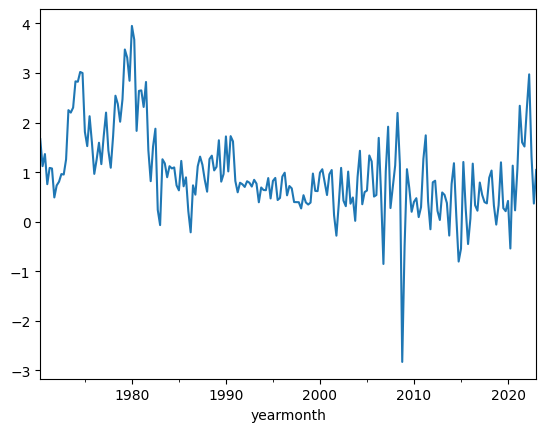

In [2]:
country_df = df[df["Country"] == "United States"]
# country_df["pi"] = (1 + country_df["inflation"]).cumprod()
country_df["pi"] = country_df["inflation"] * 100
country_df.set_index("yearmonth")["pi"].plot()

In [3]:
len(country_df)

212

# 2. Construct PF

$\pi_t = \tau_t  + \eta_t$

$\tau_t = \tau_{t-1} + \delta_{1,t} \cdot seas_1(t) + \ldots + \delta_{4,t} \cdot seas_4(t) + \epsilon_t$

$\delta_{i,t} = \delta_{i,t-1} + seas_i(t) \cdot \zeta_{\delta,t},\quad i = 1,2,3,4$

(after each step, subtract mean from deltas to get 0 delta mean.)

$\zeta_{i,t} \sim N(\mu_{i,t}, \sigma_{\zeta,i,t}^2)$

$\eta_t \sim N(0, \sigma_{\eta,t}^2)$

$\epsilon_t \sim N(0, \sigma_{\epsilon,t}^2)$

$\ln \sigma_{\eta,t}^2 = \ln \sigma_{\eta,t-1}^2 + \nu_{\eta, t}$

$\ln \sigma_{\epsilon,t}^2 = \ln \sigma_{\epsilon,t-1}^2 + \nu_{\epsilon, t}$

where $seas_i(t) = 1$ iff the season corresponding to timestamp $t$ is $i$.

In [4]:
country_df

,Country Code,IMF Country Code,Country,yearmonth,inflation,pi
29442,USA,111,United States,1970-04-01,0.016667,1.666666
29443,USA,111,United States,1970-07-01,0.011216,1.121607
29444,USA,111,United States,1970-10-01,0.013652,1.365194
29445,USA,111,United States,1971-01-01,0.007576,0.757617
29446,USA,111,United States,1971-04-01,0.010860,1.086001
...,...,...,...,...,...,...
29649,USA,111,United States,2022-01-01,0.022835,2.283482
29650,USA,111,United States,2022-04-01,0.029738,2.973779
29651,USA,111,United States,2022-07-01,0.013147,1.314736
29652,USA,111,United States,2022-10-01,0.003669,0.366938


In [6]:
import scipy
import numpy as np
from seminartools.models.base_model import BaseModel
from tqdm import trange

# nu follows a normal distribution with variance gamma
GAMMA = 0.2

# zeta follows a normal distribution with variance theta
THETA = 0.002

INIT_LNSETASQ = 0
INIT_LNSEPSILONSQ = 0
INIT_DELTA = 0

VAGUE_PRIOR_LNSETASQ_SIGMA = 3
VAGUE_PRIOR_LNSEPSILONSQ_SIGMA = 3
VAGUE_PRIOR_DELTA_SIGMA = 1
VAGUE_PRIOR_TAU_SIGMA = 1


# Unobserved Component Stochastic Volatility Stochastic Seasonality Particle Filter
class UCSVSSPF(BaseModel):
    def __init__(
        self,
        num_particles: int,
    ):
        self.num_particles = num_particles

    def fit(self, data: pd.DataFrame):
        """
        This model is not meant to be fitted to data every iteration using this method.
        Preferably, fit once on the entire dataset using `run_pf` and then
        figure out the historical predictions using the historical particles.
        """
        pass

    def run_pf(self, data: pd.DataFrame):
        """
        Run the particle filter on the data.
        """
        n = len(data)
        pi = data["pi"].values

        # Initial Particles
        # [tau, lnsetasq, lnsepsilonsq, delta1, delta2, delta3, delta4]
        X0 = np.zeros((self.num_particles, 7))
        X0[:, 0] = np.random.normal(
            size=self.num_particles, loc=1, scale=VAGUE_PRIOR_TAU_SIGMA
        )
        X0[:, 1] = np.random.normal(
            size=self.num_particles, loc=INIT_LNSETASQ, scale=VAGUE_PRIOR_LNSETASQ_SIGMA
        )
        X0[:, 2] = np.random.normal(
            size=self.num_particles,
            loc=INIT_LNSEPSILONSQ,
            scale=VAGUE_PRIOR_LNSEPSILONSQ_SIGMA,
        )

        # deltas
        for i in range(3, 7):
            X0[:, i] = np.random.normal(
                size=self.num_particles,
                loc=INIT_DELTA,
                scale=VAGUE_PRIOR_DELTA_SIGMA,
            )

        W0 = np.ones(self.num_particles) / self.num_particles

        # history of X's
        X = np.zeros((n + 1, self.num_particles, 7))
        W = np.zeros((n + 1, self.num_particles))
        X[0, :, :] = X0
        W[0, :] = W0

        # Seasonality indicator function
        # first we determine which modulo corresponds to Q1
        t0_season = (data["yearmonth"].iloc[0].month - 1) // 3

        def seas(i, t):
            """
            = 1 iff timestamp t corresponds to season i
            season 0: Q1
            ...
            season 3: Q4
            """

            return 1 if t % 4 == ((i - t0_season) % 4) else 0

        for t in trange(1, n + 1):
            # Step 1: predict and update
            W[t, :] = np.ones(self.num_particles) / self.num_particles
            for i in range(self.num_particles):
                X[t, i, 1] = np.random.normal(loc=X[t - 1, i, 1], scale=np.sqrt(GAMMA))
                X[t, i, 2] = np.random.normal(loc=X[t - 1, i, 2], scale=np.sqrt(GAMMA))
                X[t, i, 3] = (
                    np.random.normal(loc=X[t - 1, i, 3], scale=np.sqrt(THETA))
                    if seas(0, t)
                    else X[t - 1, i, 3]
                )
                X[t, i, 4] = (
                    np.random.normal(loc=X[t - 1, i, 4], scale=np.sqrt(THETA))
                    if seas(1, t)
                    else X[t - 1, i, 4]
                )
                X[t, i, 5] = (
                    np.random.normal(loc=X[t - 1, i, 5], scale=np.sqrt(THETA))
                    if seas(2, t)
                    else X[t - 1, i, 5]
                )
                X[t, i, 6] = (
                    np.random.normal(loc=X[t - 1, i, 6], scale=np.sqrt(THETA))
                    if seas(3, t)
                    else X[t - 1, i, 6]
                )
                # restrict sum of deltas to be 0
                delta_mean = np.mean(X[t, i, 3:7])
                X[t, i, 3:7] -= delta_mean

                # X[t, i, 0] = np.random.normal(loc=X[t-1, i, 0], scale=np.sqrt(np.exp(X[t, i, 2])))
                # add the seasonal noise
                X[t, i, 0] = (
                    np.random.normal(
                        loc=X[t - 1, i, 0], scale=np.sqrt(np.exp(X[t, i, 2]))
                    )
                    + X[t, i, 3] * seas(0, t)
                    + X[t, i, 4] * seas(1, t)
                    + X[t, i, 5] * seas(2, t)
                    + X[t, i, 6] * seas(3, t)
                )

            mean_vals = X[t, :, 0]
            scale_vals = np.sqrt(np.exp(X[t, :, 1]))
            W[t, :] *= scipy.stats.norm.pdf(pi[t - 1], loc=mean_vals, scale=scale_vals)
            W[t, :] = W[t, :] / np.sum(W[t, :])

            # Step 2: resample
            indices = np.random.choice(
                self.num_particles, size=self.num_particles, replace=True, p=W[t, :]
            )
            X[t, :, :] = X[t, indices, :]

        self.X = X[1:, :, :]
        self.W = W[1:, :]
        self.EX = np.mean(self.X, axis=1)
        self.Esigmaeta = np.mean(np.sqrt(np.exp(self.X[:, :, 1])), axis=1)
        self.Esigmaepsilon = np.mean(np.sqrt(np.exp(self.X[:, :, 2])), axis=1)
        self.Meff = 1 / np.sum(self.W**2, axis=1)

    def predict(self, data: pd.DataFrame) -> pd.Series:
        """
        Predict the state at time t.
        """
        if not hasattr(self, "X"):
            raise ValueError("Model has not been run_pf'd yet.")
        



# We need more particles for this model because we have more parameters
model = UCSVSSPF(num_particles=10000)
model.run_pf(country_df)

100%|██████████| 212/212 [00:26<00:00,  8.03it/s]


Text(0.5, 1.0, 'Inflation and estimated latent process')

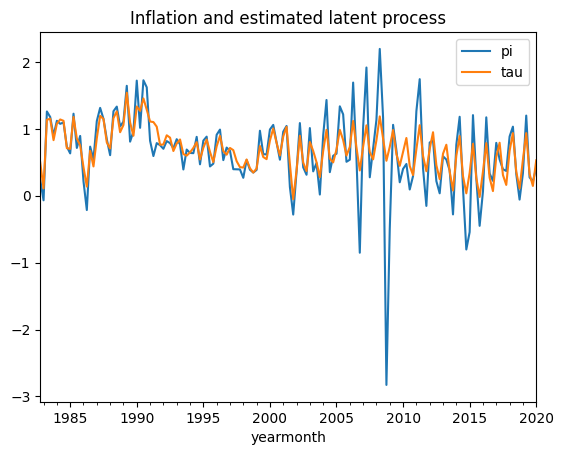

In [7]:
import matplotlib.pyplot as plt

merged = pd.concat(
    [
        country_df["pi"].reset_index(drop=True),
        pd.DataFrame(model.EX, columns=["tau", "lnsetasq", "lnsepsilonsq", "delta1", "delta2", "delta3", "delta4"]),
        pd.DataFrame(model.Esigmaeta, columns=["sigmaeta"]),
        pd.DataFrame(model.Esigmaepsilon, columns=["sigmaepsilon"]),
    ],
    axis=1,
).set_index(country_df["yearmonth"])
merged[["pi", "tau"]].iloc[50:200].plot()
plt.title("Inflation and estimated latent process")

<Axes: xlabel='yearmonth'>

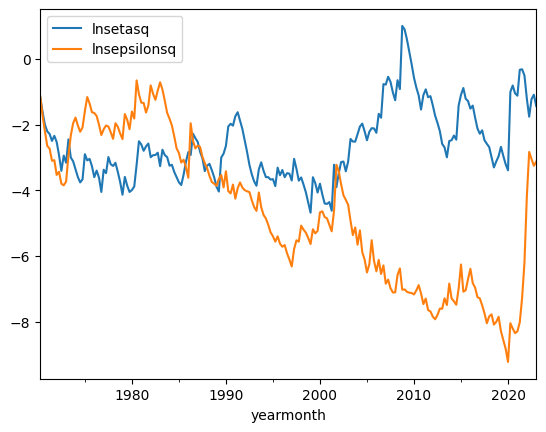

In [8]:
merged[["lnsetasq", "lnsepsilonsq"]].plot()

Text(0.5, 1.0, 'Seasonal effects over time')

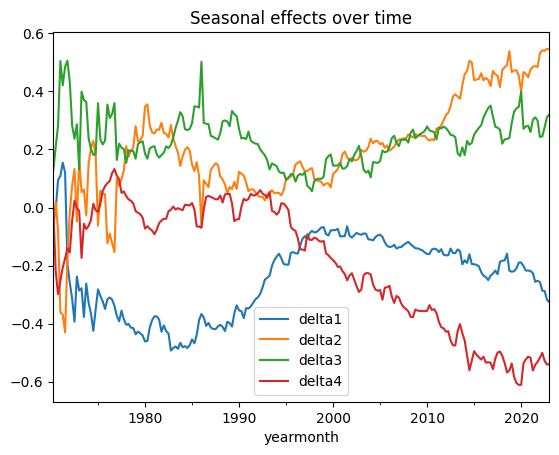

In [9]:
merged[["delta1", "delta2", "delta3", "delta4"]].plot()
plt.title("Seasonal effects over time")

Text(0.5, 1.0, 'Estimated stochastic volatility')

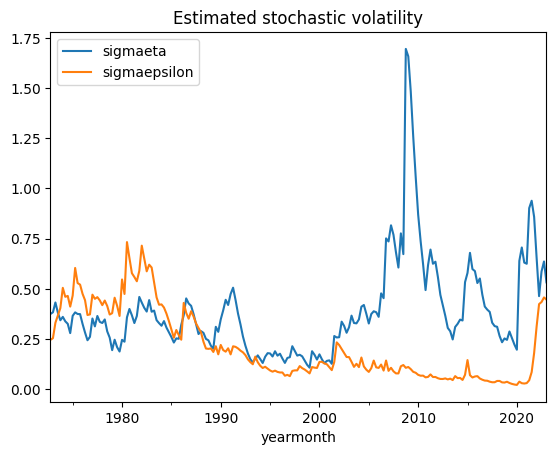

In [ ]:
merged[["sigmaeta", "sigmaepsilon"]].iloc[10:].plot()
plt.title("Estimated stochastic volatility")